In [1]:
import numpy as np
import deepwave
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import os
import torch

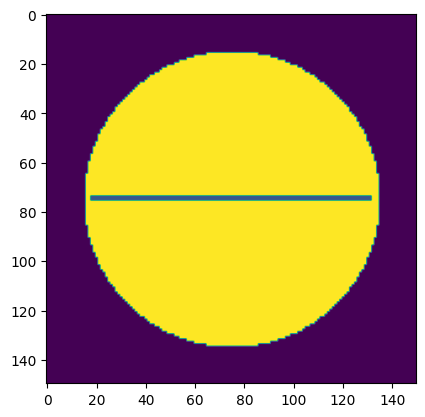

In [2]:
radius=6
vel=np.ones([150,150])*0.03

for i in range(150):
    for j in range(150):
        if (i-75)**2+(j-75)**2<(radius*10)**2:
            vel[i,j]=4.4
            
vel[74:76,18:132]=1.2

plt.imshow(vel)

In [3]:
r=radius
a=r*np.sqrt(3)/6

r1=a
r2=r/2
r3=2*a
r4=np.sqrt(7)*a
r5=3*a
r6=r

# 圆心
x0=[0]
y0=[0]
# 第一个正六边形
theta=np.linspace(0,2*np.pi,7)
x1=r1*np.cos(theta)
y1=r1*np.sin(theta)


# 第二个正六边形，旋转30度
theta=np.linspace(0,2*np.pi,7)+np.pi/6
x2=r2*np.cos(theta)
y2=r2*np.sin(theta)

# 第三个正六边形，不旋转
theta=np.linspace(0,2*np.pi,7)
x3=r3*np.cos(theta)
y3=r3*np.sin(theta)

# 第四个正六边形，不规则，逐个写出
x4_test=[5*a/2,2*a,a/2]
y4_test=[np.sqrt(3)*a/2,np.sqrt(3)*a,3*np.sqrt(3)*a/2]
x4=[]
y4=[]
#这里x4_test与y4_test写出了三个点，我们需要将这三个点分别对x轴、y轴以及原点进行对称
for i in x4_test:
    x4.append(i)
    x4.append(-i)
    x4.append(-i)
    x4.append(i)
for i in y4_test:
    y4.append(i)
    y4.append(i)
    y4.append(-i)
    y4.append(-i)

# 第五个正六边形
x5=r5*np.cos(theta)
y5=r5*np.sin(theta)

# 第六个圆弧上的24个点
theta=np.linspace(0,2*np.pi,25)
x6=r6*np.cos(theta)
y6=r6*np.sin(theta)

# 将上面所有的点横坐标都写入x_tri,纵坐标写入y_tri
x_tri=[]
y_tri=[]
for i in x0:
    x_tri.append(i)
#不读入x1[0]，因为x1[0]与x0[0]重合
for i in x1[1:]:
    x_tri.append(i)
for i in x2[1:]:
    x_tri.append(i)
for i in x3[1:]:
    x_tri.append(i)
for i in x4:
    x_tri.append(i)
for i in x5[1:]:
    x_tri.append(i)
for i in x6[1:]:
    x_tri.append(i)
for i in y0:
    y_tri.append(i)
for i in y1[1:]:
    y_tri.append(i)
for i in y2[1:]:
    y_tri.append(i)
for i in y3[1:]:
    y_tri.append(i)
for i in y4:
    y_tri.append(i)
for i in y5[1:]:
    y_tri.append(i)
for i in y6[1:]:
    y_tri.append(i)

In [8]:
receiver=[]
for i in range(len(x_tri)):
    x_tri[i]=x_tri[i]+75
    y_tri[i]=y_tri[i]+75
    receiver.append([x_tri[i],y_tri[i]])

In [4]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [30]:
for i in range(len(x_tri)):
    out = deepwave.scalar(torch.tensor(vel).type(torch.float64).to(device), grid_spacing=0.001, dt=200e-6, source_amplitudes=1e7*deepwave.wavelets.ricker(50, 500, 0.0002, 0.06).reshape(1, 1, -1).type(torch.float64).to(device),
             source_locations=torch.tensor([[[x_tri[i],y_tri[i]]]]).reshape(1,1,2).type(torch.float64).to(device),
             receiver_locations=torch.tensor(receiver).reshape(1,-1,2).type(torch.float64).to(device),
             accuracy=8,
             pml_width=5
             )
    out=out[-1].cpu().numpy()
    np.save('D:/codinglab/bayesian_opt_exper/cylinder/2dsimulate/'+str(i)+'.npy',out)
    

In [5]:
source=deepwave.wavelets.ricker(1000, 800, 0.0002, 0.06)-0.5*deepwave.wavelets.ricker(1500, 800, 0.0002, 0.06)-0.5*deepwave.wavelets.ricker(500, 800, 0.0002, 0.06)+deepwave.wavelets.ricker(2000, 800, 0.0002, 0.06)
# for i in range(10):
#     source=source+deepwave.wavelets.ricker(1100+100*i, 1000, 0.0002, 0.06)
#     source=source+deepwave.wavelets.ricker(900-100*i, 1000, 0.0002, 0.06)

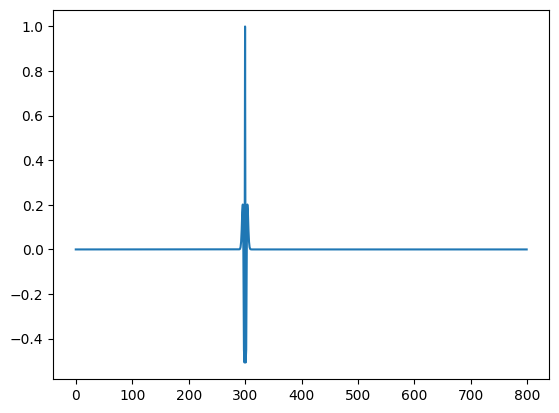

In [7]:
plt.plot(source)

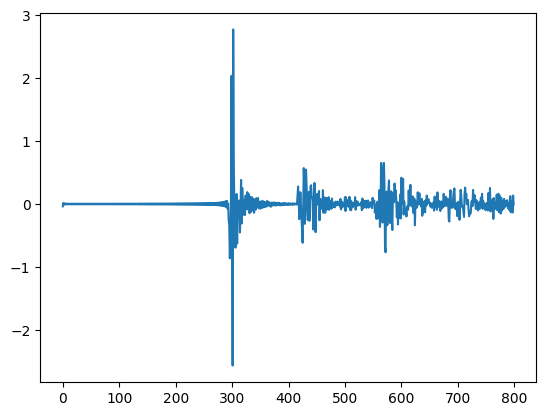

In [8]:
out=deepwave.scalar(torch.tensor(vel).type(torch.float64).to(device), grid_spacing=0.001, dt=200e-6, source_amplitudes=1e7*source.reshape(1, 1, -1).type(torch.float64).to(device),
             source_locations=torch.tensor([[[x_tri[50],y_tri[50]]]]).type(torch.float64).to(device),
             receiver_locations=torch.tensor([[[x_tri[50],y_tri[50]]]]).type(torch.float64).to(device),
             accuracy=8,
             pml_width=5
             )
plt.plot(out[-1].detach().flatten().cpu().numpy())

In [9]:
data=[]

In [10]:
for i in range(len(x_tri)):
    data.append([])
    out = deepwave.scalar(torch.tensor(vel).type(torch.float64).to(device), grid_spacing=0.001, dt=200e-6, source_amplitudes=1e7*source.reshape(1, 1, -1).type(torch.float64).to(device),
             source_locations=torch.tensor([[[x_tri[i],y_tri[i]]]]).reshape(1,1,2).type(torch.float64).to(device),
             receiver_locations=torch.tensor(receiver).reshape(1,-1,2).type(torch.float64).to(device),
             accuracy=8,
             pml_width=5
             )
    out=out[-1].detach().flatten().cpu().numpy()
    for j in range(len(x_tri)):
        data[i].append(out[0+800*j:800+800*j])
    np.save('D:/codinglab/bayesian_opt_exper/cylinder/2dsimulate/'+str(i)+'.npy',out)

In [40]:
print(len(data[0][0]))

800


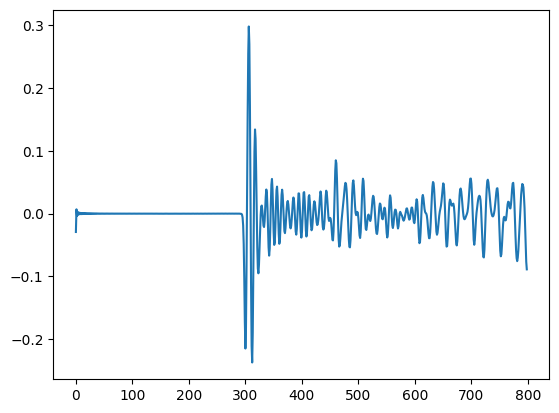

In [24]:
plt.plot(data[0][1])

2d fullwaveform inversion


source waveform

In [67]:
source=deepwave.wavelets.ricker(1000, 800, 0.0002, 0.06)-0.5*deepwave.wavelets.ricker(1500, 800, 0.0002, 0.06)-0.5*deepwave.wavelets.ricker(500, 800, 0.0002, 0.06)+deepwave.wavelets.ricker(2000, 800, 0.0002, 0.06)

model reserve

In [11]:
forward_model=np.zeros([150,150,800])
r_model=np.zeros([150,150,800])
all_points=[]
for i in range(150):
    for j in range(150):
        all_points.append([i,j])

In [11]:
def laplas(u):
    h=1
    u_xx = (np.roll(u, -1, axis=0) - 2 * u + np.roll(u, 1, axis=0)) / h**2
    u_yy = (np.roll(u, -1, axis=1) - 2 * u + np.roll(u, 1, axis=1)) / h**2
    return u_xx+u_yy

In [17]:
def fwi_forward(sensor_location,vel):
    rs=np.zeros([150,150])
    v2=np.zeros([150,150])
    for i in range(150):
        for j in range(150):
            v2[i,j]=vel[i,j]**2
    for i in range(len(sensor_location)):
        for k in range(150):
            for l in range(150):
                torch.cuda.empty_cache()
                if (k-75)**2+(l-75)**2<(radius*10)**2:
                    out=deepwave.scalar(torch.tensor(vel).type(torch.float64).to(device), grid_spacing=0.001, dt=200e-6, source_amplitudes=1e7*source.reshape(1, 1, -1).type(torch.float64).to(device),
                     source_locations=torch.tensor([[[sensor_location[i][0],sensor_location[i][1]]]]).type(torch.float64).to(device),
                     receiver_locations=torch.tensor([k,l]).reshape(1,-1,2).type(torch.float64).to(device),
                     accuracy=8,
                     pml_width=5
                     )
                    forward_model[k,l,:]=out[-1].detach().flatten().cpu().numpy()
    # 对forward_model处理，每一格都进行拉普拉斯变换
        f_laplas=laplas(forward_model)*(-1)
        #计算r的反向传播
        for j in range(len(sensor_location)):
            # print([sensor_location[j][0],sensor_location[j][1]])
            # # print(data[i][j])
            # print(forward_model[int(sensor_location[j][0]),int(sensor_location[j][1])])
            r=np.array(data[i][j])-np.array(forward_model[int(sensor_location[j][0]),int(sensor_location[j][1])])
            for k in range(150):
                for l in range(150):
                    torch.cuda.empty_cache()
                    if (k-75)**2+(l-75)**2<(radius*10)**2:
                        out=deepwave.scalar(torch.tensor(vel).type(torch.float64).to(device), grid_spacing=0.001, dt=200e-6, source_amplitudes=torch.tensor(r).reshape(1, 1, -1).type(torch.float64).to(device),
                         source_locations=torch.tensor([[[int(sensor_location[j][0]),int(sensor_location[j][1])]]]).type(torch.float64).to(device),
                         receiver_locations=torch.tensor([k,l]).reshape(1,-1,2).type(torch.float64).to(device),
                         accuracy=8,
                         pml_width=5
                         )
                        r_model[k,l,:]=out[-1].detach().flatten().cpu().numpy()
                        for m in range(800):
                            rs[k,l]=rs[k,l]+f_laplas[k,l,m]*r_model[k,l,m]
    v2=v2+rs
    for i in range(150):
        for j in range(150):
            vel[i,j]=np.sqrt(v2[i,j])
    return vel
    
            

In [13]:
def fwi_ite(sensor_location,vel):
    for i in range(10):
        vel=fwi_forward(sensor_location,vel)
    return vel

In [12]:
initvel=np.ones([150,150])*0.03

for i in range(150):
    for j in range(150):
        if (i-75)**2+(j-75)**2<(radius*10)**2:
            initvel[i,j]=4.4

In [31]:
print(len(data[0][0]))

799


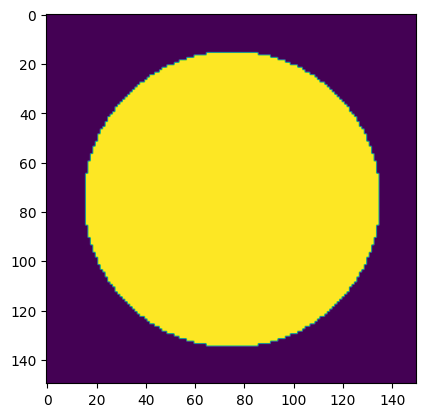

In [18]:
sensorlocation=[]
sensorlocation.append(np.array([x_tri[0],y_tri[0]]))
sensorlocation.append(np.array([x_tri[50],y_tri[50]]))
finalvel=fwi_ite(np.array(sensorlocation),initvel)
plt.imshow(finalvel)

In [13]:
torch.cuda.empty_cache()

In [16]:
n_shots=2

n_sources_per_shot = 1
n_receivers_per_shot = 2
device=torch.device('cpu')
observed_data = (torch.tensor([data[0][0],data[0][50],data[50][0],data[50][50]]).reshape(n_shots, n_receivers_per_shot, 800)).type(torch.float64).to(device)

source_amplitudes = (
    (1e7*source)
    .repeat(n_shots, n_sources_per_shot, 1).type(torch.float64).to(device)
)

v = torch.tensor(initvel).type(torch.float64).to(device).clone()
v.requires_grad_()

source_locations=torch.tensor([[[x_tri[0],y_tri[0]],[x_tri[50],y_tri[50]]]]).reshape(n_shots, n_sources_per_shot, 2).type(torch.float64).to(device)
receiver_locations=torch.tensor([[x_tri[0],y_tri[0]],[x_tri[50],y_tri[50]],[x_tri[0],y_tri[0]],[x_tri[50],y_tri[50]]]).reshape(n_shots, n_receivers_per_shot, 2).type(torch.float64).to(device)

optimiser = torch.optim.SGD([v], lr=1e9, momentum=0.9)
loss_fn = torch.nn.MSELoss()
n_epochs = 250
v_true = torch.tensor(vel).type(torch.float64).to(device)

for epoch in range(n_epochs):
    optimiser.zero_grad()
    out = deepwave.scalar(v.to(device), grid_spacing=0.001, dt=200e-6, source_amplitudes=source_amplitudes.to(device),
                     source_locations=source_locations.to(device),
                     receiver_locations=receiver_locations.to(device),
                     accuracy=8,
                     pml_width=5
                     )
    loss = loss_fn(out[-1], observed_data)
    loss.backward()
    torch.nn.utils.clip_grad_value_(
        v,
        torch.quantile(v.grad.detach().abs(), 0.98)
    )
    optimiser.step()
    
plt.imshow(v.cpu().detach().numpy())